<a href="https://colab.research.google.com/github/avisheknandi/Siamese-Network/blob/main/SiameseNetwork3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 019 Siamese Network in PyTorch with application to face similarity

[Siamese Network in PyTorch with application to face similarity](https://datahacker.rs/019-siamese-network-in-pytorch-with-application-to-face-similarity/)



# 3. Siamese Neural Networks in PyTorch

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

The dataset that we will be using is the so-called AT&T dataset. It is a gray-scaled dataset with 400 samples. You can easily download it from our GitHub profile or by running the code below.



In [ ]:
!pwd

/content


In [ ]:
!ls

data.zip  sample_data


In [ ]:
!rm -rf data

In [ ]:
!ls

data.zip  sample_data


In [ ]:
!unzip "data.zip" -d .

Archive:  data.zip
   creating: ./data/
   creating: ./data/testing/
   creating: ./data/testing/AN/
 extracting: ./data/testing/AN/S133_003_00000047-AN.png  
 extracting: ./data/testing/AN/S134_003_00000011-AN.png  
 extracting: ./data/testing/AN/S136_005_00000010-AN.png  
 extracting: ./data/testing/AN/S501_001_00000067-AN.png  
 extracting: ./data/testing/AN/S502_001_00000016-AN.png  
 extracting: ./data/testing/AN/S503_001_00000071-AN.png  
 extracting: ./data/testing/AN/S504_001_00000022-AN.png  
 extracting: ./data/testing/AN/S506_001_00000040-AN.png  
 extracting: ./data/testing/AN/S999_001_00000018-AN.png  
   creating: ./data/testing/CO/
 extracting: ./data/testing/CO/S155_002_00000012-CO - Copy.png  
 extracting: ./data/testing/CO/S155_002_00000012-CO.png  
 extracting: ./data/testing/CO/S156_002_00000021-CO - Copy.png  
 extracting: ./data/testing/CO/S156_002_00000021-CO.png  
 extracting: ./data/testing/CO/S157_002_00000011-CO - Copy.png  
 extracting: ./data/testing/CO/S15

In [ ]:
!ls

data  data.zip	sample_data


In [ ]:
#!wget https://github.com/avisheknandi/Facial-Expression-Recognition-Siamese-Network/blob/main/CKPLUSTOPGROUPED.zip
#!rm -rf data
#!unzip "CKPLUSTOPGROUPED.zip" -d .

For some easy plotting and visualization, I have created two helper functions as shown in the code block below.

In [ ]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In comparison with the classification neural networks, that take in one image and one label, our Siamese neural network will take as input 2 images and 1 label. To accomplish this, we need to create our own custom Dataset class, SiameseNetworkDataset. It will accept a path where the images are and also the transformations which to apply.

How does this class work?

It will read two images and return them, as well as their label. If they are in the same category, the same person, it will return 0, and otherwise, it will return 1.

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

How do we use this custom dataset class?

First, we initialize the dataset by calling the ImageFolderfunction and passing the path to the training set. We define a simple transformation of only a resize and transformation to tensors. Then, we can call our custom class and pass in the transformation, as well as the folder_datasetwe created at the top.

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/training/")

# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

For simple visualization purposes let’s look at this example. We create a DataLoaderof the siamese_datasetand extract the first batch only. We combine each combination of images, because our siamese_datasetwill return two images and one label, and print out the labels.

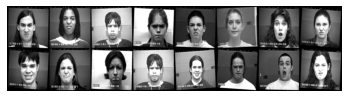

[1. 0. 1. 0. 1. 1. 0. 0.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Looking from left to right, we have our images stacked vertically. The first two images are not of the same person and we have a label of 1. The second two images are also not of the same person, the label is as well 1. But, the 3rd image is of the same person and the label is 0 here, as well as the 4th pair of images.

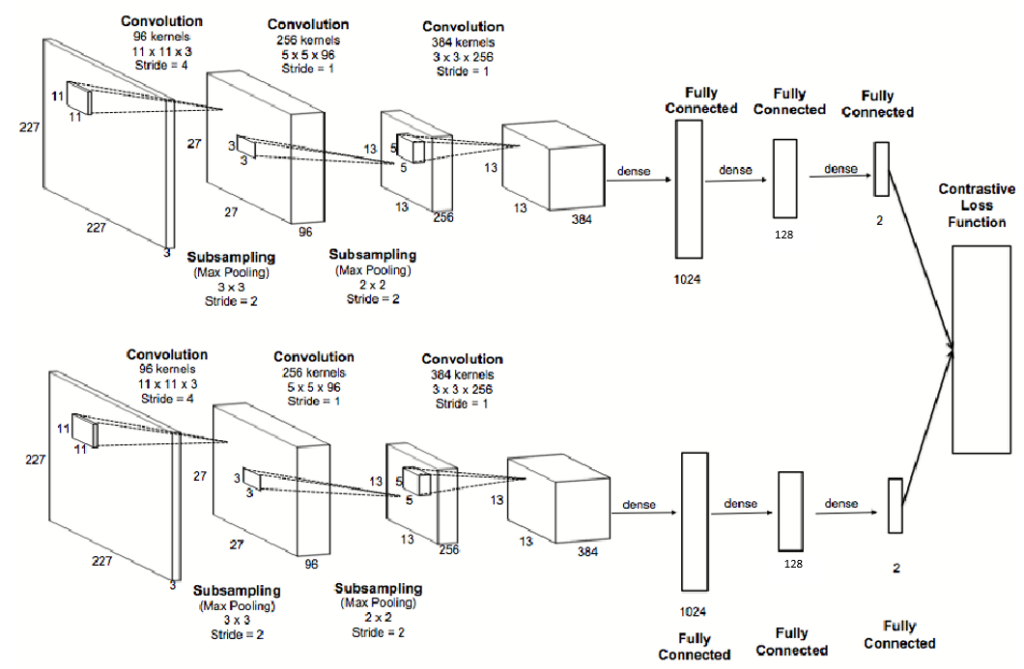

We can see that we have two identical networks, one on top and one below. We pass two images through the two networks and get an output which we pass into the Contrastive Loss Function to calculate the distance or dissimilarity. Now let’s transfer this diagram into PyTorch code.

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

Our network is called SiameseNetworkand we can see that it looks almost identical to a standard CNN. The only difference that can be noticed is that we have two forward functions ( forward_onceand forward). Why is that?

We mentioned that we pass two images through the same network. This forward_oncefunction, called inside the forwardfunction, will take an image as input and pass it into the network. The output is stored into output1and the output from the second image is stored into output2, as we can see in the forwardfunction. In this way, we have managed to input two images and get two outputs from our model.

We have seen how the loss function should look like, now let’s code it. We create a class called ContrastiveLossand similarly as in the model class we will have a forwardfunction. In this forwardfunction we will write our contrastive loss equation from the paragraph before.

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

Now that we defined the loss function that we will use, our next step would be definining the data that we will use for the training, and create a data loader object. It will accept our siamese_datasetand also shuffle our data. We will set the num_workersto 8 and also the batch_size to 64.

We will also initialize our model, as well as the loss and optimizer.

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Following the flow diagram from the top, we can start creating the training loop. We iterate 100 times and extract the two images as well as the label. We zero the gradients and pass our two images into the network, and the network outputs two vectors. The two vectors, and the label, are then fed into the criterion (loss function) that we defined. We backpropagate and optimize. For some visualization purposes and to see how our model is performing on the training set, so we will print the loss every 10 batches.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 2.306396484375

Epoch number 1
 Current loss 1.5939280986785889

Epoch number 2
 Current loss 1.2304552793502808

Epoch number 3
 Current loss 1.1848986148834229

Epoch number 4
 Current loss 1.0416853427886963

Epoch number 5
 Current loss 1.2398409843444824

Epoch number 6
 Current loss 1.0867342948913574

Epoch number 7
 Current loss 1.3363441228866577

Epoch number 8
 Current loss 1.1606544256210327

Epoch number 9
 Current loss 1.3859304189682007

Epoch number 10
 Current loss 1.3197494745254517

Epoch number 11
 Current loss 1.165317177772522

Epoch number 12
 Current loss 1.0166290998458862

Epoch number 13
 Current loss 1.355666160583496

Epoch number 14
 Current loss 0.9848814010620117

Epoch number 15
 Current loss 1.2189608812332153

Epoch number 16
 Current loss 0.998142659664154

Epoch number 17
 Current loss 1.2399892807006836

Epoch number 18
 Current loss 1.2793601751327515

Epoch number 19
 Current loss 1.2314612865447998

Epoch number 20
 

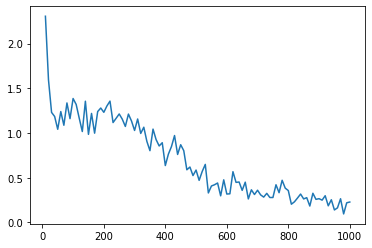

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

We can now analyze the results. The first thing we can see is that the loss started around 2.2 and ended at a number pretty close to 0.

It would be interesting to see the model in action. Now comes the part where we test our model on images it didn’t see before. As we have done before, we create a Siamese Network Dataset using our custom dataset class, but now we point it to the test folder.

As the next steps, we extract the first image from the first batch and iterate 5 times to extract the 5 images in the next 5 batches because we set that each batch contains one image. Then, combining the two images horizontally, using torch.cat(), we get a pretty clear visualization of which image is compared to which.

We pass in the two images into the model and obtain two vectors, which are then passed into theF.pairwise_distance() function, this will calculate the euclidean distance between the two vectors. Using this distance, we can as a metric of how dissimilar the two faces are.

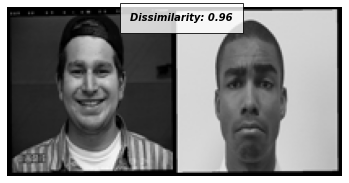

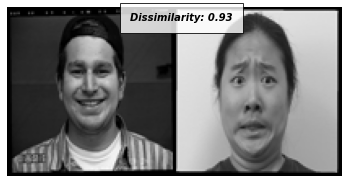

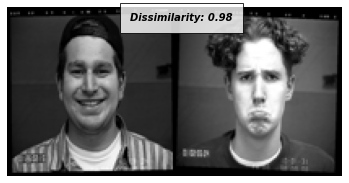

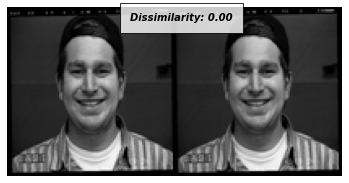

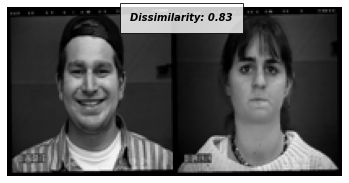

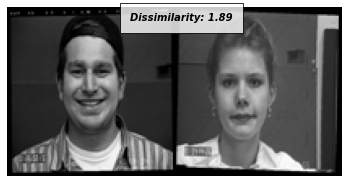

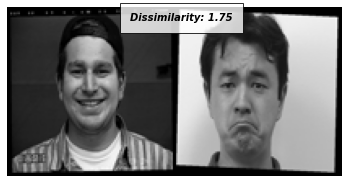

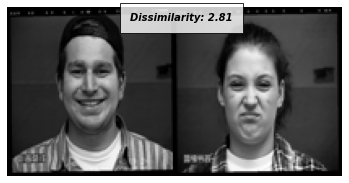

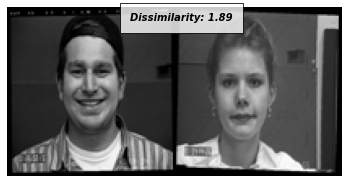

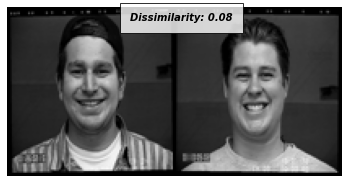

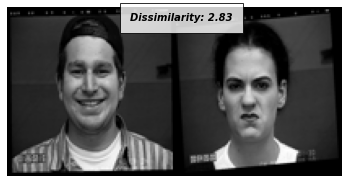

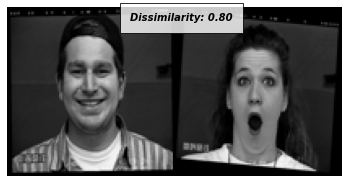

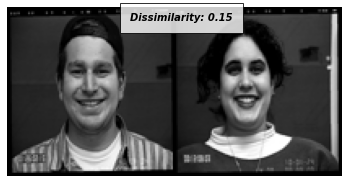

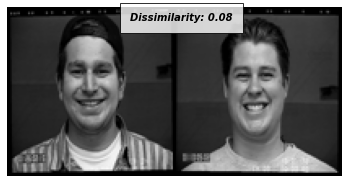

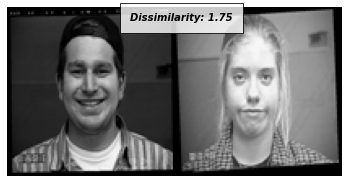

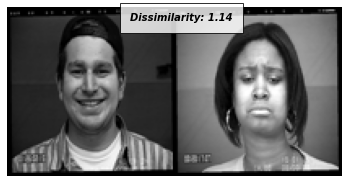

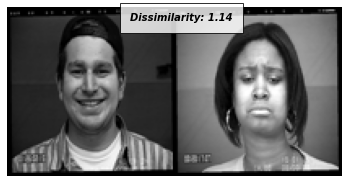

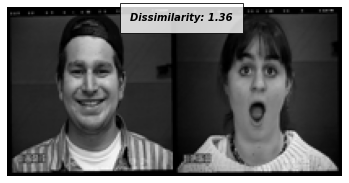

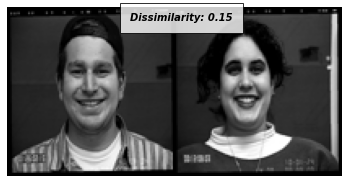

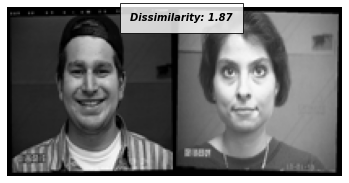

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(20):
    # Iterate over 5 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')